In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
def construct_dataframe(filename):
    
    event_acc = EventAccumulator(filename)
    event_acc.Reload()
    
    values = []
    
    w_times, step_nums, label_cpi = zip(*event_acc.Scalars('acc/label_cpi'))
    _, _, label_npi = zip(*event_acc.Scalars('acc/label_npi'))
    _, _, label_neut = zip(*event_acc.Scalars('acc/label_neut'))
    _, _, label_prot = zip(*event_acc.Scalars('acc/label_prot'))
    _, _, loss = zip(*event_acc.Scalars('loss'))
    try:
        _, _, images_per_second = zip(*event_acc.Scalars('images_per_second'))
    except:
        images_per_second = [-999] * len(loss)
    
    df = pd.DataFrame(columns=['step', 
                               'wall_time', 
                               'images_per_second', 
                               'loss', 
                               'acc/label_cpi', 'acc/label_npi', 'acc/label_neut', 'acc/label_prot'])
    
    counter = 0
    for s, wt, ips, l, cpi, npi, neut, prot in zip(step_nums, w_times, images_per_second, loss, label_cpi, label_npi, label_neut, label_prot): 
        df.loc[counter] = [s, wt, ips, l, cpi, npi, neut, prot]
        counter += 1
        
    return df



def construct_dataframe_dict(to_plot):
    
    df_train = {}
    df_test = {}
    
    
    for simple_name, dim, n, r, mb, bpl, nf, lrs, extra_label in zip(to_plot['simple_name'], 
                                                                     to_plot['dim'], 
                                                                     to_plot['n'], 
                                                                     to_plot['r'], 
                                                                     to_plot['mb'], 
                                                                     to_plot['bpl'], 
                                                                     to_plot['nf'], 
                                                                     to_plot['lrs'], 
                                                                     to_plot['extra_label']):
        
#         filename = 'log_sbnd_'+dim+'_n'+n+'_r'+r+'_mb'+mb+'_bpl'+bpl+'_nf'+nf+'_lrs'+lrs+'_'+extra_label
        filename = 'log_dune_'+dim+'_n24_r6_mb256_bpl2_nf32_lr1_lrsexp_range_clr_bntrue_lrfalse_new'
#         filename = '/Users/mdeltutt/Downloads/log_sbnd/' + filename
        filename = '/Users/mdeltutt/Downloads/logs_dune_highstat/' + filename
        print ('Using file:', filename)
    
        df_train[simple_name] = construct_dataframe(filename)
        df_test[simple_name] = construct_dataframe(filename+'/test/')
    
    return df_train, df_test

In [7]:
line_colors = {}
line_colors['2d_n5_r6'] = colors[0]
line_colors['3d_n5_r6'] = colors[1]
line_colors['2d_n1_r6'] = colors[0]
line_colors['3d_n1_r6'] = colors[1]
line_colors['3d_n10_r6'] = colors[1]

label_name = {}
label_name['2d_n5_r6'] = '2D'
label_name['3d_n5_r6'] = '3D'
label_name['2d_n1_r6'] = '2D'
label_name['3d_n1_r6'] = '3D'
label_name['3d_n10_r6'] = '3D'

vline = {}
vline['2d_n5_r6'] = 1600
vline['3d_n5_r6'] = 5000
vline['2d_n1_r6'] = 1600
vline['3d_n1_r6'] = 5000
vline['3d_n10_r6'] = 5000

def make_plot(acc_type, test_only=False, xlim=[0, 1000], sparse_level=20):

    fig = plt.figure(figsize=(20,23),facecolor='w') #plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,12))
    
    ax = plt.subplot(3, 2, 1)
    for i, name in enumerate(dfs_train):
#         print name
        x      = dfs_train[name]['step'] - dfs_train[name]['step'][0]
        x_test = dfs_test[name]['step']
        y      = dfs_train[name]['acc/label_neut']
        y_test = dfs_test[name]['acc/label_neut']
        
        # Sparsify, keep one entry every "sparse_level"
        x      = x[::sparse_level]
        x_test = x_test[::sparse_level]
        y      = y[::sparse_level]
        y_test = y_test[::sparse_level]
        
        if not test_only: 
            plt.plot(x, y,      'o-',  color=line_colors[name], markersize=1, label=label_name[name] + ', Train')
        plt.plot(x_test, y_test, 'o--', color=lighten_color(line_colors[name], 1.2), markersize=3, label=label_name[name] + ', Test')
        
        if '2d' in name:
            plt.axvline(x=vline[name], linewidth=2, color=line_colors[name], linestyle='dashdot', label='End of training for 2D')
        # plt.axhline(y=0.85, color='r', linestyle='-')
        
    ax.legend(numpoints=1, loc='upper left')
    leg=plt.legend(fontsize=20,loc=0)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
    plt.xlim(xlim)
    plt.ylabel('Accuracy',fontsize=23)
    plt.xlabel('Step',fontsize=23)
    plt.tick_params(labelsize=20)
    plt.title(r'Neutrino ID Classification ($\nu_e$, $\nu_\mu$, $NC$)', loc='right', fontsize=22)
    ax.grid(True)
    
    
    ax = plt.subplot(3, 2, 2)
    for i, name in enumerate(dfs_train):

        x      = dfs_train[name]['step'] - dfs_train[name]['step'][0]
        x_test = dfs_test[name]['step']
        y      = dfs_train[name]['acc/label_cpi']
        y_test = dfs_test[name]['acc/label_cpi']
        
        # Sparsify, keep one entry every "sparse_level"
        x      = x[::sparse_level]
        x_test = x_test[::sparse_level]
        y      = y[::sparse_level]
        y_test = y_test[::sparse_level]
    
        if not test_only: 
            plt.plot(x, y,      'o-',  color=line_colors[name], markersize=1, label=label_name[name] + ', Train')
        plt.plot(x_test, y_test, 'o--', color=lighten_color(line_colors[name], 1.2), markersize=3, label=label_name[name] + ', Test')
        
        if '2d' in name:
            plt.axvline(x=vline[name], linewidth=2, color=line_colors[name], linestyle='dashdot', label='End of training for 2D')
        
    ax.legend(numpoints=1, loc='upper left')
    leg=plt.legend(fontsize=20,loc=0)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
    plt.xlim(xlim)
    plt.ylabel('Accuracy',fontsize=23)
    plt.xlabel('Step',fontsize=23)
    plt.tick_params(labelsize=20)
    plt.title(r'$\pi^{\pm}$ Classification ($N_{\pi^\pm} = 0, 1+$)', loc='right', fontsize=22)
    ax.grid(True)
    
    
    ax = plt.subplot(3, 2, 3)
    for i, name in enumerate(dfs_train):

        x      = dfs_train[name]['step'] - dfs_train[name]['step'][0]
        x_test = dfs_test[name]['step']
        y      = dfs_train[name]['acc/label_npi']
        y_test = dfs_test[name]['acc/label_npi']
        
        # Sparsify, keep one entry every "sparse_level"
        x      = x[::sparse_level]
        x_test = x_test[::sparse_level]
        y      = y[::sparse_level]
        y_test = y_test[::sparse_level]
    
        if not test_only: 
            plt.plot(x, y,      'o-',  color=line_colors[name], markersize=1, label=label_name[name] + ', Train')
        plt.plot(x_test, y_test, 'o--', color=lighten_color(line_colors[name], 1.2), markersize=3, label=label_name[name] + ', Test')
        
        if '2d' in name:
            plt.axvline(x=vline[name], linewidth=2, color=line_colors[name], linestyle='dashdot', label='End of training for 2D')
        
    ax.legend(numpoints=1, loc='upper left')
    leg=plt.legend(fontsize=20,loc=0)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
    plt.xlim(xlim)
    plt.ylabel('Accuracy',fontsize=23)
    plt.xlabel('Step',fontsize=23)
    plt.tick_params(labelsize=20)
    plt.title(r'$\pi^0$ Classification ($N_{\pi^0} = 0, 1+$)', loc='right', fontsize=22)
    ax.grid(True)
    
    
    ax = plt.subplot(3, 2, 4)
    for i, name in enumerate(dfs_train):

        x      = dfs_train[name]['step'] - dfs_train[name]['step'][0]
        x_test = dfs_test[name]['step']
        y      = dfs_train[name]['acc/label_prot']
        y_test = dfs_test[name]['acc/label_prot']
        
        # Sparsify, keep one entry every "sparse_level"
        x      = x[::sparse_level]
        x_test = x_test[::sparse_level]
        y      = y[::sparse_level]
        y_test = y_test[::sparse_level]
    
        if not test_only: 
            plt.plot(x, y,      'o-',  color=line_colors[name], markersize=1, label=label_name[name] + ', Train')
        plt.plot(x_test, y_test, 'o--', color=lighten_color(line_colors[name], 1.2), markersize=3, label=label_name[name] + ', Test')
        
        if '2d' in name:
            plt.axvline(x=vline[name], linewidth=2, color=line_colors[name], linestyle='dashdot', label='End of training for 2D')
        
    ax.legend(numpoints=1, loc='upper left')
    leg=plt.legend(fontsize=20,loc=0)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
    plt.xlim(xlim)
    plt.ylabel('Accuracy',fontsize=23)
    plt.xlabel('Step',fontsize=23)
    plt.tick_params(labelsize=20)
    plt.title(r'Number of Protons Classification ($N_P = 0, 1, 2+$)', loc='right', fontsize=22)
    ax.grid(True)
    
    
    ax = plt.subplot(3, 2, 5)
    for i, name in enumerate(dfs_train):

        x      = dfs_train[name]['step'] - dfs_train[name]['step'][0]
        x_test = dfs_test[name]['step']
        y      = dfs_train[name]['loss']
        y_test = dfs_test[name]['loss']
        
        # Sparsify, keep one entry every "sparse_level"
        x      = x[::sparse_level]
        x_test = x_test[::sparse_level]
        y      = y[::sparse_level]
        y_test = y_test[::sparse_level]
    
        if not test_only: 
            plt.plot(x, y,      'o-',  color=line_colors[name], markersize=1, label=label_name[name] + ', Train')
        plt.plot(x_test, y_test, 'o--', color=lighten_color(line_colors[name], 1.2), markersize=3, label=label_name[name] + ', Test')
        
        if '2d' in name:
            plt.axvline(x=vline[name], linewidth=2, color=line_colors[name], linestyle='dashdot', label='End of training for 2D')
        
    ax.legend(numpoints=1, loc='upper left')
    leg=plt.legend(fontsize=20,loc=0)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')
    plt.xlim(xlim)
    plt.ylabel('Loss',fontsize=23)
    plt.xlabel('Step',fontsize=23)
    plt.tick_params(labelsize=20)
    ax.grid(True)
    
    plt.tight_layout()
    
#     plt.ylim(0.4,1)
    if not test_only: 
        plt.savefig('paper_figures/network_performances/accuracy_loss.pdf')
    else:
        plt.savefig('paper_figures/network_performances/accuracy_loss_testonly.pdf')
    plt.show()

In [8]:
to_plot = {}
to_plot['simple_name'] = ['2d_n5_r6', '3d_n5_r6']
to_plot['dim'        ] = ['2d', '3d']
to_plot['n'          ] = ['5', '5']
to_plot['r'          ] = ['6', '6']
to_plot['mb'         ] = ['64', '64']
to_plot['bpl'        ] = ['2', '2']
to_plot['nf'         ] = ['32', '32']
to_plot['lrs'        ] = ['triangle_clr', 'triangle_clr']
to_plot['extra_label'] = ['', '']
labels                 = ['3D', '2D']

dfs_train, dfs_test = construct_dataframe_dict(to_plot)

Using file: /Users/mdeltutt/Downloads/logs_dune_highstat/log_dune_2d_n24_r6_mb256_bpl2_nf32_lr1_lrsexp_range_clr_bntrue_lrfalse_new
Using file: /Users/mdeltutt/Downloads/logs_dune_highstat/log_dune_3d_n24_r6_mb256_bpl2_nf32_lr1_lrsexp_range_clr_bntrue_lrfalse_new


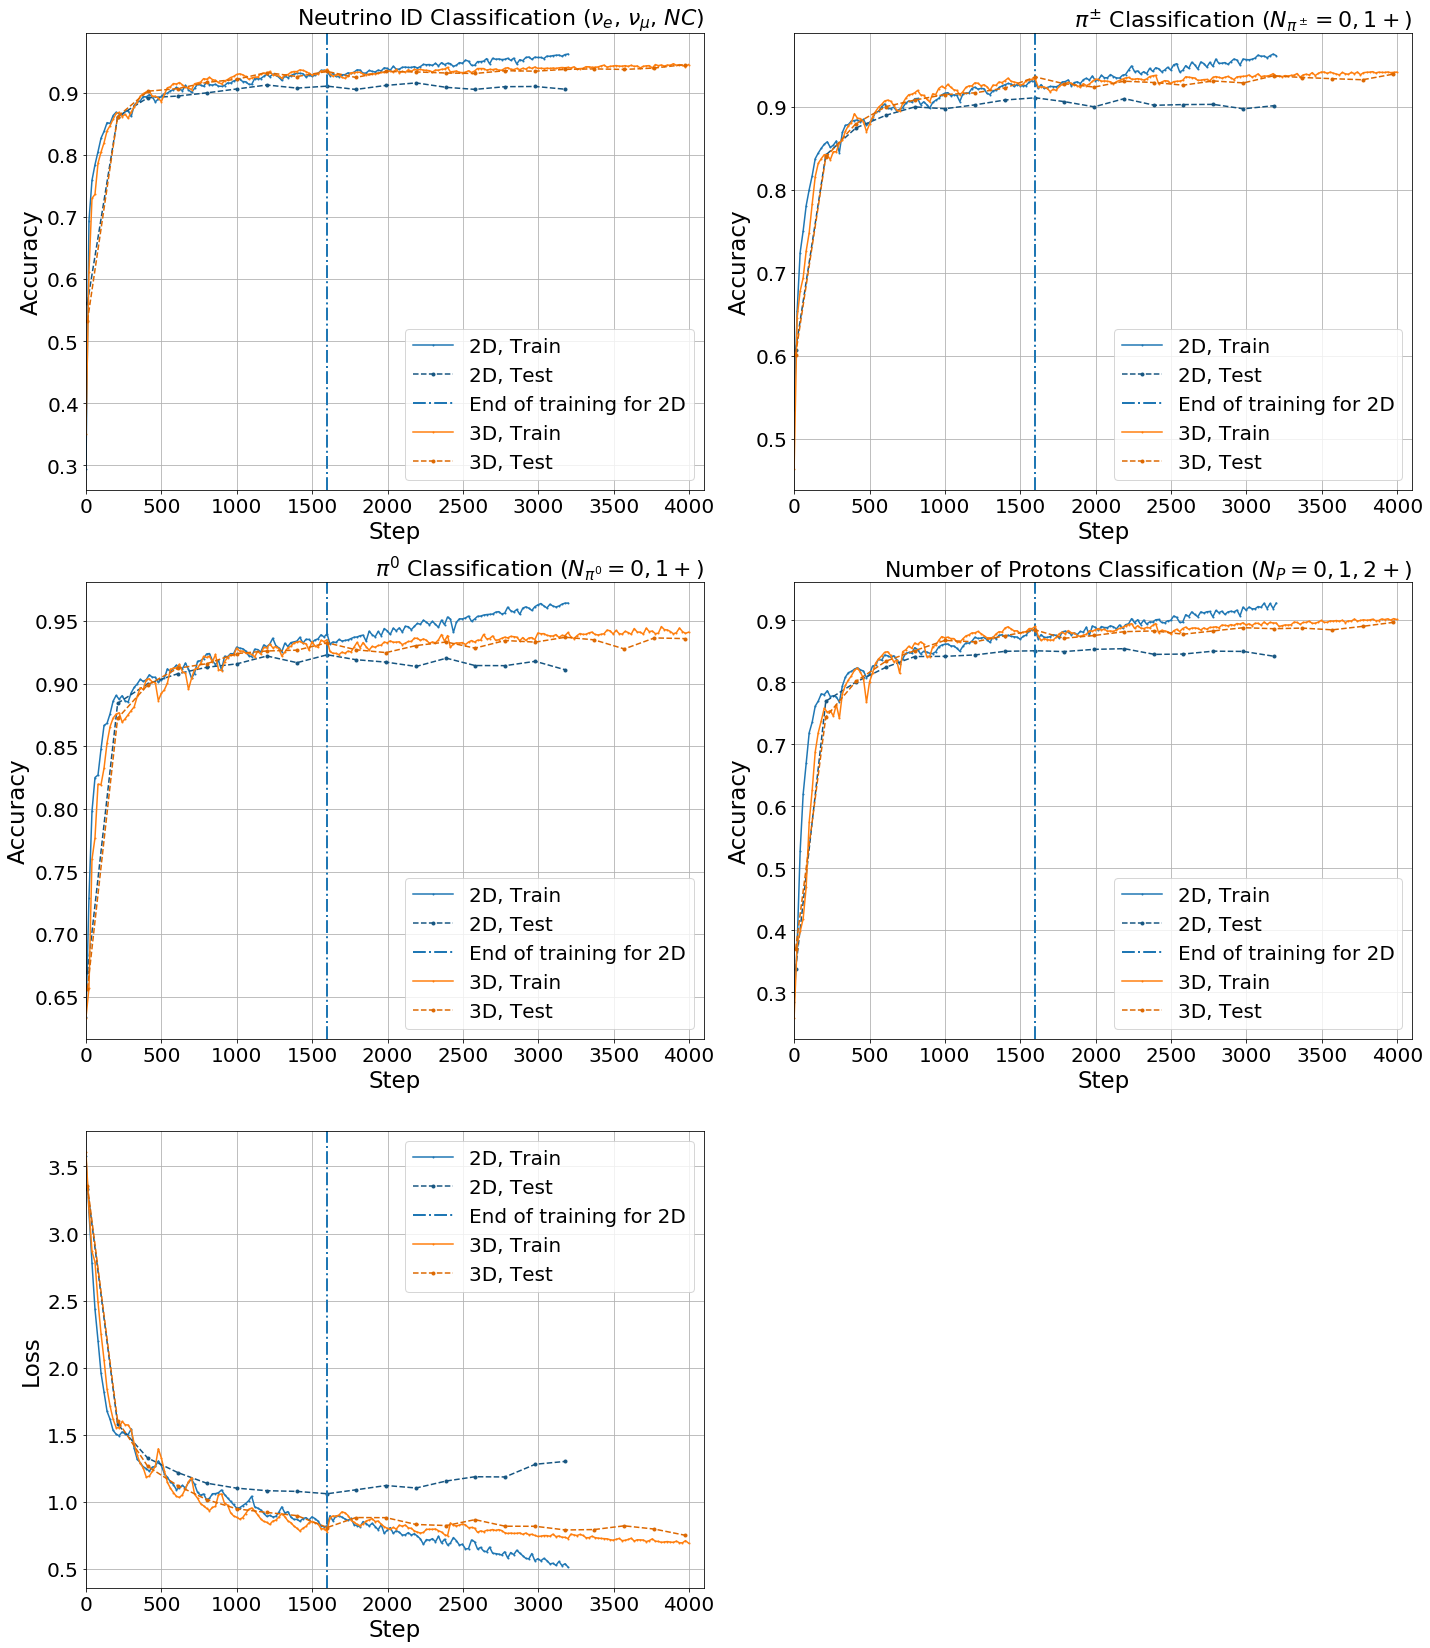

In [9]:
make_plot(acc_type = 'acc/label_neut', xlim=[0, 4100], test_only=False)

# Old plots

Using file: /Users/mdeltutt/Downloads/log_sbnd/log_sbnd_2d_n1_r6_mb64_bpl2_nf32_lrstriangle_clr_
Using file: /Users/mdeltutt/Downloads/log_sbnd/log_sbnd_3d_n1_r6_mb64_bpl2_nf32_lrstriangle_clr_


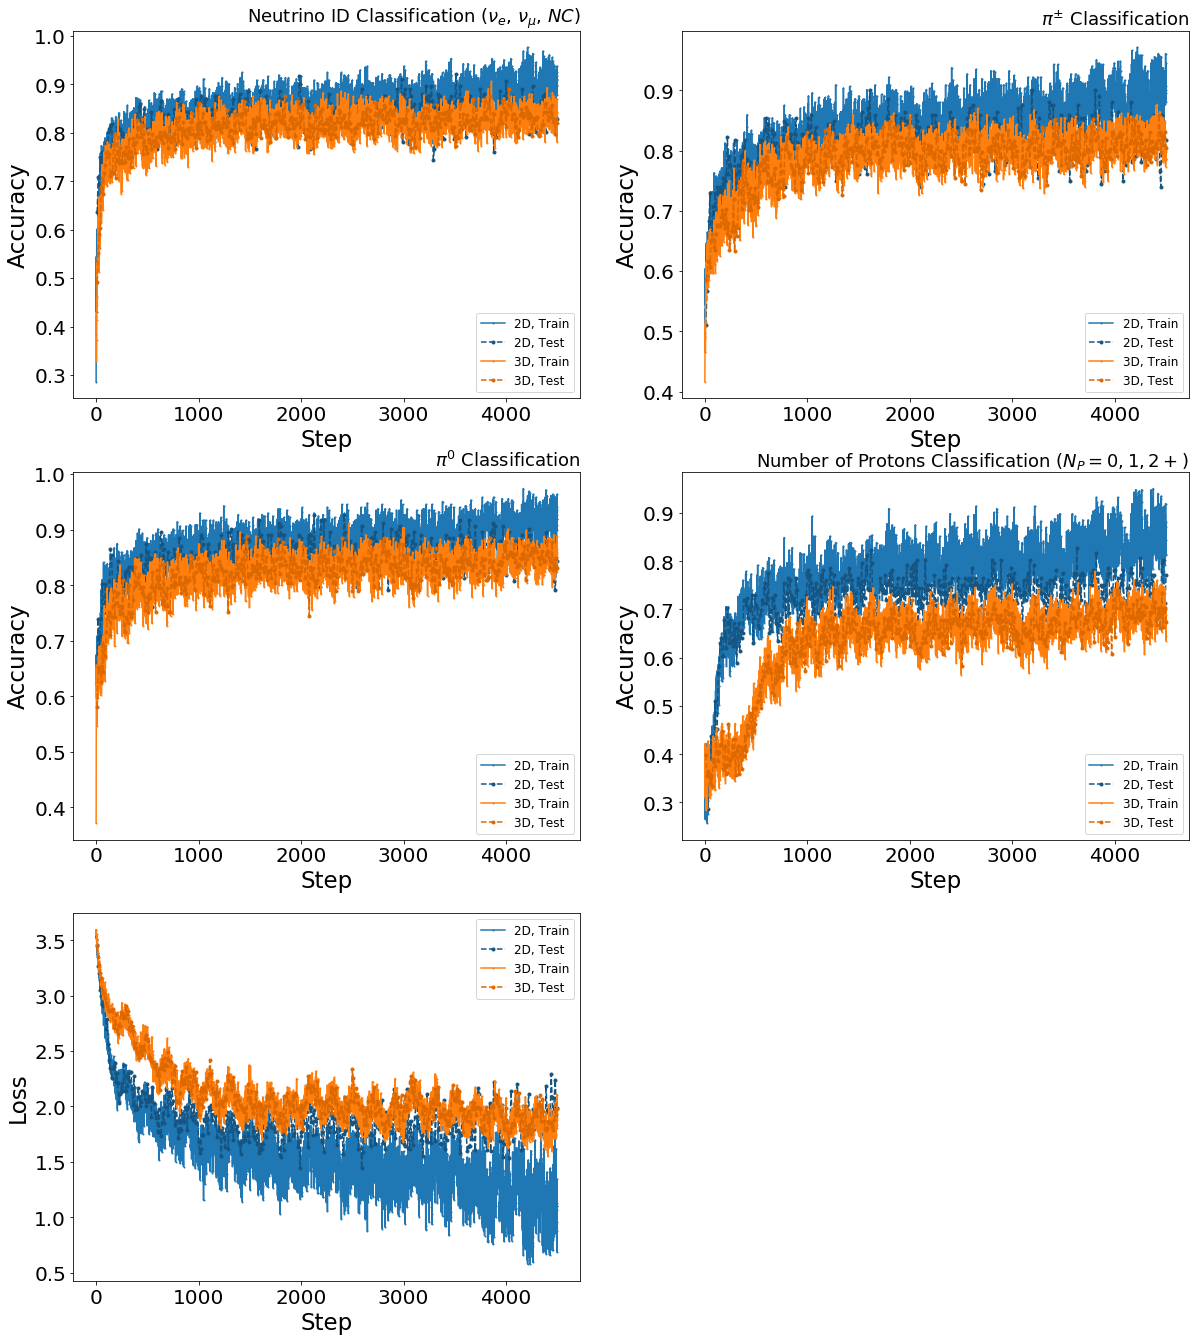

In [14]:
to_plot = {}
to_plot['simple_name'] = ['2d_n1_r6', '3d_n1_r6']
to_plot['dim'        ] = ['2d', '3d']
to_plot['n'          ] = ['1', '1']
to_plot['r'          ] = ['6', '6']
to_plot['mb'         ] = ['64', '64']
to_plot['bpl'        ] = ['2', '2']
to_plot['nf'         ] = ['32', '32']
to_plot['lrs'        ] = ['triangle_clr', 'triangle_clr']
to_plot['extra_label'] = ['', '']
labels                 = ['2D', '3D']

dfs_train, dfs_test = construct_dataframe_dict(to_plot)
make_plot(acc_type = 'acc/label_neut', test_only=False)

Using file: /Users/mdeltutt/Downloads/log_sbnd/log_sbnd_2d_n1_r6_mb64_bpl2_nf32_lrstriangle_clr_
Using file: /Users/mdeltutt/Downloads/log_sbnd/log_sbnd_3d_n10_r6_mb64_bpl2_nf32_lrstriangle_clr_


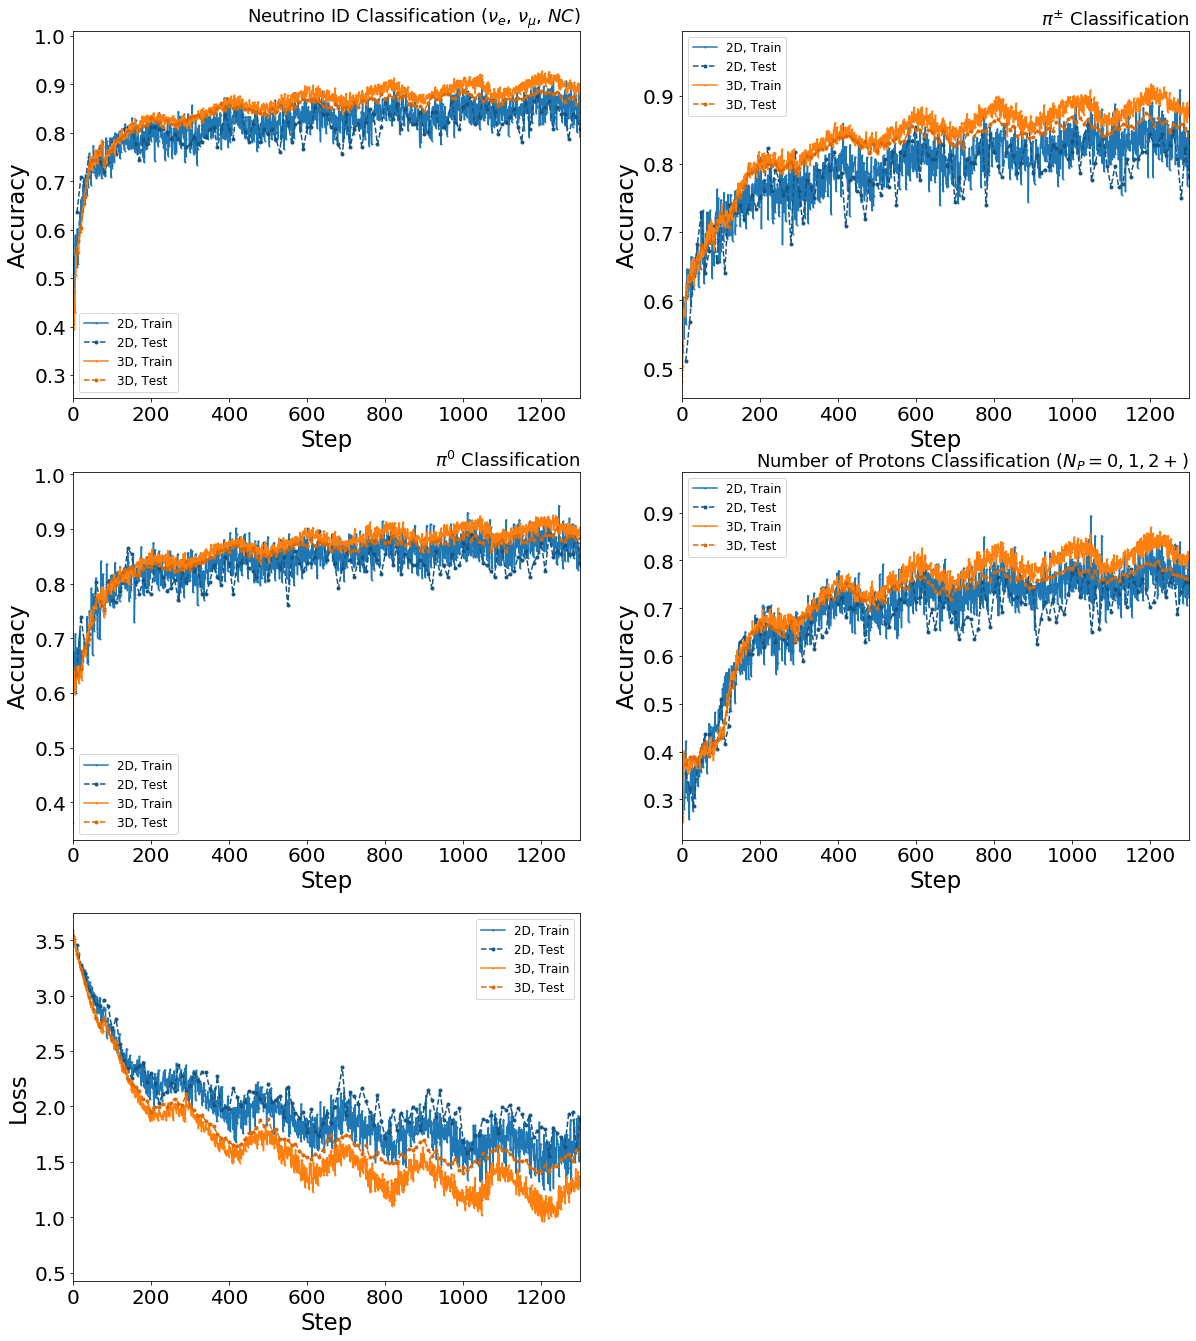

In [26]:
to_plot = {}
to_plot['simple_name'] = ['2d_n1_r6', '3d_n10_r6']
to_plot['dim'        ] = ['2d', '3d']
to_plot['n'          ] = ['1', '10']
to_plot['r'          ] = ['6', '6']
to_plot['mb'         ] = ['64', '64']
to_plot['bpl'        ] = ['2', '2']
to_plot['nf'         ] = ['32', '32']
to_plot['lrs'        ] = ['triangle_clr', 'triangle_clr']
to_plot['extra_label'] = ['', '']
labels                 = ['2D', '3D']

dfs_train, dfs_test = construct_dataframe_dict(to_plot)
make_plot(acc_type = 'acc/label_neut', test_only=False, xlim=[0, 1300])

In [8]:
tags = ['n1_r1', 'n1_r6', 'n10_r6']
n_gpu = [1, 6, 60]
mb = [512, 3072, 30720]

sample_size = 40837 # 3d
x_scale = []
for g in n_gpu:
    x_scale.append((512. * g) / sample_size)

In [ ]:
dfs = {}
for i, t in enumerate(tags):
    event_acc = EventAccumulator('/Users/deltutto/Downloads/log_sbnd/log_sbnd_3d_' + t + '_mb' + str(mb[i]) + '_bpl2_classic/')
    event_acc.Reload()
    w_times, step_nums, vals = zip(*event_acc.Scalars('acc/label_cpi'))
    dfs[t] = {}
    dfs[t]['wall_time'] = w_times
    dfs[t]['step'] = step_nums
    dfs[t]['acc/label_cpi'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_npi'))
    dfs[t]['acc/label_npi'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_neut'))
    dfs[t]['acc/label_neut'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_prot'))
    dfs[t]['acc/label_prot'] = vals
    
    w_times, step_nums, vals = zip(*event_acc.Scalars('loss'))
    dfs[t]['loss'] = vals
    
    w_times, step_nums, vals = zip(*event_acc.Scalars('images_per_second'))
    dfs[t]['images_per_second'] = vals

In [ ]:
dfs_test = {}
for i, t in enumerate(tags):
    event_acc = EventAccumulator('/Users/deltutto/Downloads/log_sbnd/log_sbnd_3d_' + t + '_mb' + str(mb[i]) + '_bpl2_classic/test/')
    event_acc.Reload()
    w_times, step_nums, vals = zip(*event_acc.Scalars('acc/label_cpi'))
    dfs_test[t] = {}
    dfs_test[t]['wall_time'] = w_times
    dfs_test[t]['step'] = step_nums
    dfs_test[t]['acc/label_cpi'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_npi'))
    dfs_test[t]['acc/label_npi'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_neut'))
    dfs_test[t]['acc/label_neut'] = vals
    
    _, _, vals = zip(*event_acc.Scalars('acc/label_prot'))
    dfs_test[t]['acc/label_prot'] = vals
    
    w_times, step_nums, vals = zip(*event_acc.Scalars('loss'))
    dfs_test[t]['loss'] = vals

## Calculating wall time average

In [ ]:
wall_time_step = []
for t in tags:
    # To numpy
    wt = np.asarray(dfs[t]['wall_time'])
    # Selects first n entries
    wt = wt[:500]
    v = np.diff(wt)
    m = np.mean(v)
    print ('Average wall time for 1 step for', t, m)
    wall_time_step.append(m)

# Accuracy

In [ ]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Accuracy vs. epoch

In [ ]:
acc_type = 'acc/label_neut'

fig = plt.figure(figsize=(20,15),facecolor='w') #plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,12))

ax = plt.subplot(2, 2, 1)
for i, t in enumerate(tags):
    x      = (np.asarray(dfs[t]['step']) - dfs[t]['step'][0]) * x_scale[i]
    x_test = (np.asarray(dfs_test[t]['step'])) * x_scale[i]
    y = dfs[t][acc_type]
    y_test = dfs_test[t][acc_type]
    plt.plot(x,      y,      'o-',  color=colors[i], markersize=1, label= 'Train: ' + str(n_gpu[i]) + ' GPUs ')
    plt.plot(x_test, y_test, 'o--', color=lighten_color(colors[i], 1.2), markersize=3, label= 'Test:  ' + str(n_gpu[i]) + ' GPUs ')
plt.axhline(y=0.85, color='r', linestyle='-')
ax.legend(numpoints=1, loc='upper left')
leg=plt.legend(fontsize=12,loc=0)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.ylabel('Accuracy',fontsize=23)
plt.xlabel('Epoch',fontsize=23)
plt.tick_params(labelsize=20)
plt.ylim(0.4,1)

ax = plt.subplot(2, 2, 2)
for i, t in enumerate(tags):
    x      = (np.asarray(dfs[t]['step']) - dfs[t]['step'][0])
    x_test = (np.asarray(dfs_test[t]['step']))
    y = dfs[t][acc_type]
    y_test = dfs_test[t][acc_type]
    plt.plot(x,      y,      'o-',  color=colors[i], markersize=1, label= 'Train: ' + str(n_gpu[i]) + ' GPUs ')
    plt.plot(x_test, y_test, 'o--', color=lighten_color(colors[i], 1.2), markersize=3, label= 'Test:  ' + str(n_gpu[i]) + ' GPUs ')
plt.axhline(y=0.85, color='r', linestyle='-')
ax.legend(numpoints=1, loc='upper left')
leg=plt.legend(fontsize=12,loc=0)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.ylabel('Accuracy',fontsize=23)
plt.xlabel('Step',fontsize=23)
plt.tick_params(labelsize=20)
plt.ylim(0.4,1)

ax = plt.subplot(2, 2, 3)
for i, t in enumerate(tags):
    x      = (np.asarray(dfs[t]['step']) - dfs[t]['step'][0]) * wall_time_step[i] / 60.
    x_test = (np.asarray(dfs_test[t]['step'])) * wall_time_step[i] / 60.
    y = dfs[t][acc_type]
    y_test = dfs_test[t][acc_type]
    plt.plot(x,      y,      'o-',  color=colors[i], markersize=1, label= 'Train: ' + str(n_gpu[i]) + ' GPUs ')
    plt.plot(x_test, y_test, 'o--', color=lighten_color(colors[i], 1.2), markersize=3, label= 'Test:  ' + str(n_gpu[i]) + ' GPUs ')
plt.axhline(y=0.85, color='r', linestyle='-')
ax.legend(numpoints=1, loc='upper left')
leg=plt.legend(fontsize=12,loc=0)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.ylabel('Accuracy',fontsize=23)
plt.xlabel('Wall Time [minutes]',fontsize=23)
plt.tick_params(labelsize=20)
plt.ylim(0.4,1)

# ax = plt.subplot(2, 2, 4)
# for i, t in enumerate(tags):
#     x      = (np.asarray(dfs[t]['step']) - dfs[t]['step'][0]) * x_scale[i]
#     x_test = (np.asarray(dfs_test[t]['step'])) * x_scale[i]
#     plt.plot(x,      y,      'o-',  color=colors[i], markersize=1, label= 'Train: ' + str(n_gpu[i]) + ' GPUs ')
#     plt.plot(x_test, y_test, 'o--', color=lighten_color(colors[i], 1.2), markersize=3, label= 'Test:  ' + str(n_gpu[i]) + ' GPUs ')
# ax.legend(numpoints=1, loc='upper left')
# leg=plt.legend(fontsize=12,loc=0)
# leg_frame=leg.get_frame()
# leg_frame.set_facecolor('white')
# plt.ylabel('Accuracy',fontsize=23)
# plt.xlabel('Epoch',fontsize=23)
# plt.tick_params(labelsize=20)
# plt.ylim(0.4,0.93)

fig.savefig('accuracy.pdf')
fig